# Auction
* 500 Buyers
* \# Painint Train / Test: 2000 / 1000
* Choose top-10
* Evaluation Metric: Rate of choosing the top-K (Recall)


# Problems
* Negative values in price
* Number of testing paining are NOT 1000 

In [1]:
NUM_BUYER = 500
NUM_TRAIN = 2000
NUM_TEST = 1000 - 1

import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture


def read_price(f_name):    
    with open(f_name, 'r') as f:
        data = np.array([list(map(float, line.strip().split(' '))) for line in f])
    assert len(data) == NUM_BUYER
    assert data.shape[1] == (NUM_TRAIN if 'train' in f_name else NUM_TEST)
    return data

    
def read_category(f_name):    
    with open(f_name, 'r') as f:
        data = np.array([int(e.strip()) for e in f.readlines()])
    assert len(data) == NUM_TRAIN if 'train' in f_name else NUM_TEST
    return data


def scale_to_origin(train, test):
    grand_min = min(np.min(train), np.min(test))
    if grand_min >= 0:
        print(f"Min price: {grand_min} is already above 0")
    train -= grand_min
    test -= grand_min
    assert min(np.min(train), np.min(test)) == 0
    return train, test


def get_win_buyer(data):
    return np.argmax(data, axis=0)


def boradcast_const_pred(pred, k, num_test=NUM_TEST):
    return np.tile(pred, reps=num_test).reshape(num_test, -1)


def get_mean_pred(train, k, num_test):
    return boradcast_const_pred(train.mean(1).argsort()[::-1][:k], k, num_test)


def recall(pred, ans):
    assert len(pred) == len(ans)
    return np.array([a in topk for a, topk in zip(ans, pred)]).mean()


def get_user_features(train, n_components=128, method='NMF'):
    mf_model = eval(method)(n_components=n_components)
    user_features = mf_model.fit_transform(train)
    return user_features


def get_cls_pred(train, user_features, k, n_pick_per_cls):
    n_clusters = k // n_pick_per_cls
    cls_model = KMeans(n_clusters=n_clusters).fit(user_features)

    bucket = [[] for _ in range(cls_model.n_clusters)]
    pred = []
    for u_id, c_id in enumerate(cls_model.predict(user_features)):
        bucket[c_id].append(u_id) 
    for user_ids in bucket:
        user_ids = np.array(user_ids)
        pred.extend(user_ids[train[user_ids].mean(1).argsort()[-n_pick_per_cls:]])
    return pred


def get_gmm_pred(train, user_features, k, n_pick_per_cls):
    n_components = k // n_pick_per_cls
    gmm = GaussianMixture(n_components=n_components).fit(user_features)
    prob = gmm.predict_proba(user_features)
    
    bucket = [[] for _ in range(gmm.n_components)]
    pred = []
    for u_id, c_id in enumerate(gmm.predict(user_features)):
        bucket[c_id].append(u_id) 
    for user_ids in bucket:
        user_ids = np.array(user_ids)
        pred.extend(user_ids[train[user_ids].mean(1).argsort()[-n_pick_per_cls:]])
    return pred


def normal_cdf(train, test, k=10):
    max_recall = -1
    for idx, cutoff in enumerate([100, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000]):
        mean = np.mean(train, axis=1)
        std = np.std(train, axis=1)


        cdf = 1 - norm.cdf((cutoff - mean) / std)
        prop = np.argsort(cdf)[-k:]
        recall_k = np.mean([np.argmax(d) in prop for d in test.T]) * 100
        if recall_k >= max_recall:
            i = idx
            max_recall = recall_k
            final_prop = prop
    return final_prop


def result(pred_dict, test, k=10):
#     assert all([len(pred[0]) == k for _, pred in pred_dict.items()])
    ans = get_win_buyer(test)
    pred_random_test = np.random.randint(k, size=(len(test[0]), k))

    recall_random_test = recall(pred_random_test, ans)
    recall_random_theory = k / len(test)

    print(f"Recall@{k}\n"
          f"Random:\t\t\t{100 * recall_random_test:.6f}%\n"
          f"Random (theory):\t{100 * recall_random_theory:.6f}%\n" +
          f"".join([f"{name}\t\t\t{100 * recall(boradcast_const_pred(pred, k, len(test[0])), ans):.6f}%\n" for name, pred in pred_dict.items()]))

# Basic

In [2]:
train = read_price('Auction/basic-train.txt')
test = read_price('Auction/basic-test.txt')
train, test = scale_to_origin(train, test)

## Distrubution of user prices

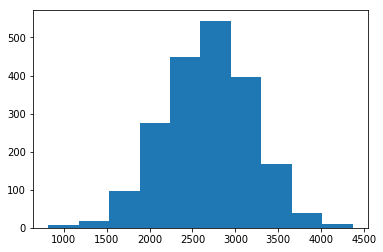

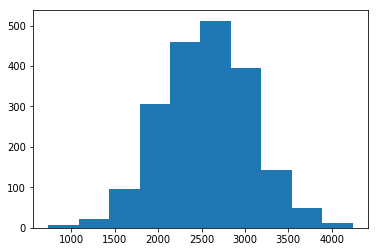

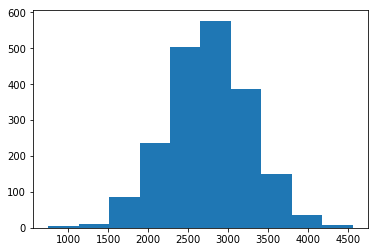

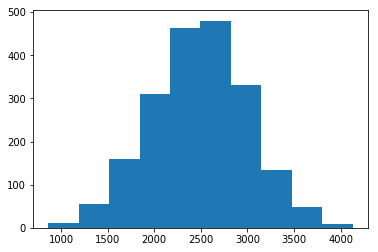

In [3]:
plt.hist(train[np.random.randint(len(train))]); plt.show()
plt.hist(train[np.random.randint(len(train))]); plt.show()
plt.hist(train[np.random.randint(len(train))]); plt.show()
plt.hist(train[np.random.randint(len(train))]); plt.show()

## Histogram of std of users' prices

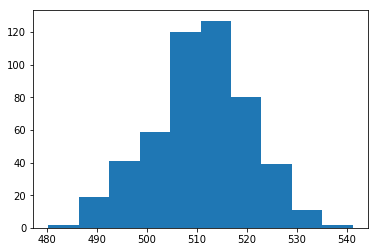

In [4]:
plt.hist(np.std(train, axis=1)); plt.show()

In [5]:
user_features = get_user_features(train, n_components=64, method='NMF')

In [6]:
n_pick_per_cls = 2
for k in [1, 3, 5, 10, 20, 30]:
    k *= n_pick_per_cls
    result({'Mean': get_mean_pred(train, k, len(test[1])),
            'Gaussian': normal_cdf(train, test, k),
            'Cls': get_cls_pred(train, user_features, k, n_pick_per_cls),
            'Gmm': get_gmm_pred(train, user_features, k, n_pick_per_cls)
           },
           test,
           k=k)

Recall@2
Random:			0.000000%
Random (theory):	0.400000%
Mean			5.405405%
Gaussian			5.405405%
Cls			5.405405%
Gmm			5.405405%

Recall@6
Random:			1.401401%
Random (theory):	1.200000%
Mean			10.210210%
Gaussian			10.910911%
Cls			10.810811%
Gmm			10.210210%

Recall@10
Random:			1.401401%
Random (theory):	2.000000%
Mean			15.315315%
Gaussian			15.315315%
Cls			13.813814%
Gmm			14.514515%

Recall@20
Random:			3.003003%
Random (theory):	4.000000%
Mean			22.622623%
Gaussian			22.722723%
Cls			19.119119%
Gmm			20.020020%

Recall@40
Random:			5.905906%
Random (theory):	8.000000%
Mean			33.733734%
Gaussian			33.633634%
Cls			29.729730%
Gmm			29.629630%

Recall@60
Random:			8.008008%
Random (theory):	12.000000%
Mean			42.642643%
Gaussian			43.143143%
Cls			37.237237%
Gmm			38.138138%



# Advance

In [7]:
train = read_price('Auction/advanced-train.txt')
test = read_price('Auction/advanced-test.txt')
cat_train = read_category('Auction/advanced-train-category.txt')
cat_test = read_category('Auction/advanced-test-category.txt')

train, test = scale_to_origin(train, test)
ori_train = train
ori_test = test

train = {k: train[:, cat_train==k] for k in [1, 2, 3]}
# test = {k: test[:, cat_test==k] for k in [1, 2, 3]}

display(pandas.Series(cat_train).value_counts())
display(pandas.Series(cat_test).value_counts())

1    677
3    669
2    654
dtype: int64

3    342
2    334
1    323
dtype: int64

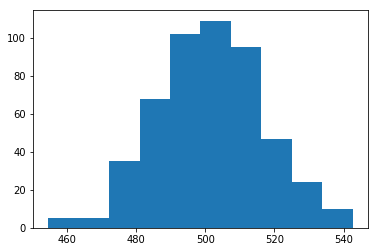

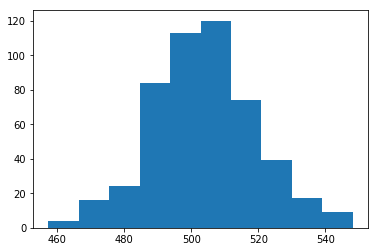

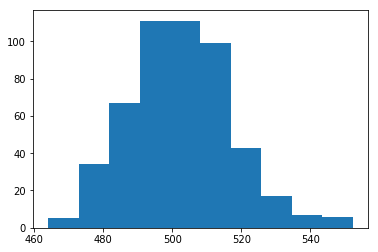

In [8]:
for _, t in train.items():
    plt.hist(np.std(t, axis=1)); plt.show()

In [9]:
method = 'NMF'
n_components = 32
user_features = {k: get_user_features(mat, n_components, method) for k, mat in train.items()}

ori_feat = get_user_features(ori_train, n_components, method)
user_features = {k: ori_feat for k, _ in train.items()}

In [10]:
def combine_mean(k):
    pred = np.empty((NUM_TEST, k))
    pred[cat_test==1] = get_mean_pred(train[1], k, sum(cat_test==1))
    pred[cat_test==2] = get_mean_pred(train[2], k, sum(cat_test==2))
    pred[cat_test==3] = get_mean_pred(train[3], k, sum(cat_test==3))
    return pred

def combine_cls(k, n_pick_per_cls):
    pred = np.empty((NUM_TEST, k))
    for part in [1, 2, 3]:
        pred[cat_test==part] = get_cls_pred(train[part], user_features[part], k, n_pick_per_cls)
    return pred

def combine_gmm(k, n_pick_per_cls):
    pred = np.empty((NUM_TEST, k))
    for part in [1, 2, 3]:
        pred[cat_test==part] = get_gmm_pred(train[part], user_features[part], k, n_pick_per_cls)
    return pred

def combine_gaussian(k, n_pick_per_cls):
    pred = np.empty((NUM_TEST, k))
    for part in [1, 2, 3]:
        pred[cat_test==part] = normal_cdf(train[part], ori_test, k)
    return pred

n_pick_per_cls = 2
for k in [1, 3, 4, 5, 10, 20]:
    k *= n_pick_per_cls
    result({'Mean': combine_mean(k),
            'Gaussian': combine_gaussian(k, -1),
            'Cls': combine_cls(k, n_pick_per_cls),
            'Gmm': combine_gmm(k, n_pick_per_cls)
           },
           test,
           k=k)

Recall@2
Random:			0.300300%
Random (theory):	0.400000%
Mean			4.104104%
Gaussian			4.104104%
Cls			4.104104%
Gmm			4.104104%

Recall@6
Random:			0.400400%
Random (theory):	1.200000%
Mean			9.109109%
Gaussian			8.808809%
Cls			8.708709%
Gmm			8.508509%

Recall@8
Random:			0.900901%
Random (theory):	1.600000%
Mean			11.311311%
Gaussian			11.511512%
Cls			10.210210%
Gmm			10.110110%

Recall@10
Random:			0.800801%
Random (theory):	2.000000%
Mean			13.113113%
Gaussian			13.213213%
Cls			12.312312%
Gmm			12.112112%

Recall@20
Random:			2.002002%
Random (theory):	4.000000%
Mean			20.120120%
Gaussian			20.720721%
Cls			18.518519%
Gmm			17.717718%

Recall@40
Random:			3.903904%
Random (theory):	8.000000%
Mean			30.630631%
Gaussian			31.031031%
Cls			27.427427%
Gmm			27.427427%

